In [3]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as colors

from jax import vmap
from jax import random

from vivarium.environments.braitenberg.render import render, render_history

### Simulation state

The ***state*** of a simulation is composed of 4 elements:


- ***Simulator State***: This element contains general information about the simulator, such as the size of the environment, the maximum number of agents and objects, and other global settings that define the overall behavior of the simulation and ... parameters for the connection with clients if run in server mode.

- ***Entity State***: This element stores information which is common to agents and objects below. It typically includes physical parameters such as position, speed, mass, or friction. 

The reason they are located here instead of the Agent or Object States is that it facilitates the computation of the physical simulation step. We are considering simplifying this in the future.

- ***Agent State***: This element focuses on the agents in the simulation, which are primarily based on [Braitenberg vehicles](https://en.wikipedia.org/wiki/Braitenberg_vehicle) at the moment. It includes information about their behavior, wheel diameter, speed multipliers, maximum speed, and other agent-specific parameters that determine how they react to their environment and entities within it.

- ***Object State***: This element provides information about the objects present in the simulation. Currently, it mainly consists of the objects' color, but it can be expanded to include additional object-specific parameters as needed.


In the next cells, we'll explain step by step how to initialize a state.

<!-- All parameters used in a simulation

<div style="font-size: 80%;">

```yaml
agents:
  behavior: 1
  color: blue
  max_speed: 10.0
  prox_cos_min: 0.0
  prox_dist_max: 40.0
  speed_mul: 1.0
  theta_mul: 1.0
  wheel_diameter: 2.0

entities:
  agents_positions: null
  diameter: 5.0
  existing_agents: null
  existing_objects: null
  friction: 0.1
  mass_center: 1.0
  mass_orientation: 0.125
  objects_positions: null
  seed: 0

objects:
  color: red

simulator:
  box_size: 100.0
  collision_alpha: 0.5
  collision_eps: 0.1
  dt: 0.1
  freq: 40.0
  max_agents: 10
  max_objects: 2
  neighbor_radius: 100.0
  num_steps_lax: 4
  to_jit: true
  use_fori_loop: false


```

</div> -->

### 1 - Create the simulator state

The Simulator State encapsulates information about the simulation environment, including its size, the maximum number of objects and agents, physical parameters for collisions, and other relevant settings. It also stores parameters related to the simulation's execution, such as whether to JIT-compile the update functions and the use of fori_loop. Additionally, it contains data for any connected client, like the simulation speed and interface update frequency.

In [ ]:
from vivarium.environments.braitenberg.selective_sensing_classes import State

box_size = 100. # size of the environment (it is a torus)
max_agents = 10 # max number of agents in the environment 
max_objects = 2 # max number of objects in the environment
num_steps_lax = 4 # Number of updates in the environment per steps 
dt = 0.01 # dt used in physics simulation updates
freq = -1 # frequency of steps (set to -1 if not used with a client)
neighbor_radius = 100. # radius entities to compute their neigbors (useful with large simulations)
to_jit = True # wether to jit the update function in the simulation or not 
use_fori_loop = False # wether to use fori_loops in the step function (accelerate the simulation)
collision_alpha = 0.5 # collision parameter in the physics engine
collision_eps = 0.2 # collision parameter in the physics engine

simulator_state = SimulatorState(
    idx=jnp.array([0]),
    box_size=jnp.array([box_size]),              
    max_agents=jnp.array([max_agents]),
    max_objects=jnp.array([max_objects]),
    num_steps_lax=jnp.array([num_steps_lax], dtype=int),
    dt=jnp.array([dt], dtype=float),
    freq=jnp.array([freq], dtype=float),
    neighbor_radius=jnp.array([neighbor_radius], dtype=float),
    to_jit= jnp.array([1*to_jit]),
    use_fori_loop=jnp.array([1*use_fori_loop]),
    collision_alpha=jnp.array([collision_alpha]),
    collision_eps=jnp.array([collision_eps]))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### 2 - Create the entities state

Contains all physical parameters (position, mass, momentum, friction ...) about all entities of the system (agents, objects). We store all the data in jax arrays of length n_entities (max_agents + max_objects). Because those arrays encompass information about agents but also objects, we define an array entity_types to know the type of each entity. We also have an array called exists, that defines which entity exist or not. This is because we have to keep arrays of same shape with jax, so we can't just add new agents to a list for example (that is also why we need to define max_agents / objects in advance).

In [4]:
from vivarium.simulator.states import EntityState, EntityType
from jax_md.rigid_body import RigidBody

n_dims = 2 # 2D world
diameter = 5. # diameter of entities
friction = 0.1 # friction of entities with the "floor"
mass_center = 1. # mass of entities 
mass_orientation = 0.125 # mass orientation of entities
existing_agents = 10 # defines how many agents exist among the max number of agents
existing_objects = 2 # same for objects
seed = 0 # random seed used to initialize positions and orientations

n_entities = max_agents + max_objects # we store the entities data in jax arrays of length max_agents + max_objects 

key = random.PRNGKey(seed)
key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

# Assign random positions to each entity in the environment
agents_positions = random.uniform(key_agents_pos, (max_agents, n_dims)) * box_size
objects_positions = random.uniform(key_objects_pos, (max_objects, n_dims)) * box_size
positions = jnp.concatenate((agents_positions, objects_positions))

# Assign random orientations between 0 and 2*pi to each entity
orientations = random.uniform(key_orientations, (n_entities,)) * 2 * jnp.pi

# Assign types to the entities
agents_entities = jnp.full(max_agents, EntityType.AGENT.value)
object_entities = jnp.full(max_objects, EntityType.OBJECT.value)
entity_types = jnp.concatenate((agents_entities, object_entities), dtype=int)

# Define arrays with existing entities
exists_agents = jnp.concatenate((jnp.ones((existing_agents)), jnp.zeros((max_agents - existing_agents))))
exists_objects = jnp.concatenate((jnp.ones((existing_objects)), jnp.zeros((max_objects - existing_objects))))
exists = jnp.concatenate((exists_agents, exists_objects), dtype=int)

# We use the RigidBody class from jax_md to represent the position, force and mass of entities 
# see https://jax-md.readthedocs.io/en/main/jax_md.rigid_body.html
entity_state = EntityState(
    position=RigidBody(center=positions, orientation=orientations),
    momentum=None,
    force=RigidBody(center=jnp.zeros((n_entities, 2)), orientation=jnp.zeros(n_entities)),
    mass=RigidBody(center=jnp.full((n_entities, 1), mass_center), orientation=jnp.full((n_entities), mass_orientation)),
    entity_type=entity_types,
    entity_idx = jnp.array(list(range(max_agents)) + list(range(max_objects))),
    diameter=jnp.full((n_entities), diameter),
    friction=jnp.full((n_entities), friction),
    exists=exists
    )

### 3 - Create the agents state

All information about the agents that are not shared by other entities. At the moment, the agents are braitenberg vehicles, that is why they have behaviors, wheels, motors, proximeter ... 

The agents perceive the environment trough proximeters, and the behavior determines motor activations according to proximeter activations. They are implemented in [this file](../vivarium/simulator/behaviors.py).

In [5]:
from vivarium.simulator.states import AgentState
from vivarium.simulator.behaviors import behavior_name_map

behavior = behavior_name_map['AGGRESSION'] # 1 of the 4 pre-implement behavior of agents
wheel_diameter = 2. # diameter of vehicle wheels
speed_mul = 1. # speed multiplier for the agents
max_speed = 10. # max speed of agents
theta_mul = 1. # orientation speed multiplier
prox_dist_max = 40. # maximum range of proximeters
prox_cos_min = 0. # cosinus of proximeter detection angle
agents_color = jnp.array([0., 0., 1.]) # color (in rgb format) 

agents_state = AgentState(
    # idx in the entities (ent_idx) state to map agents information in the different data structures
    ent_idx=jnp.arange(max_agents, dtype=int), 
    prox=jnp.zeros((max_agents, 2)),
    motor=jnp.zeros((max_agents, 2)),
    behavior=jnp.full((max_agents), behavior),
    wheel_diameter=jnp.full((max_agents), wheel_diameter),
    speed_mul=jnp.full((max_agents), speed_mul),
    max_speed=jnp.full((max_agents), max_speed),
    theta_mul=jnp.full((max_agents), theta_mul),
    proxs_dist_max=jnp.full((max_agents), prox_dist_max),
    proxs_cos_min=jnp.full((max_agents), prox_cos_min),
    proximity_map_dist=jnp.zeros((max_agents, 1)),
    proximity_map_theta=jnp.zeros((max_agents, 1)),
    color=jnp.tile(agents_color, (max_agents, 1))
    )

### 4 - Create objects state

Do the same for objects, here we only specify their color and their corresponding index in the entities dataclass.

In [6]:
from vivarium.simulator.states import ObjectState

objects_color = jnp.array([1., 0., 0.]) # set the color to red here 

# Compute the idx in entities state
start_idx, stop_idx = max_agents, max_agents + max_objects 
objects_ent_idx = jnp.arange(start_idx, stop_idx, dtype=int) 

objects_state = ObjectState(
    ent_idx=objects_ent_idx,
    color=jnp.tile(objects_color, (max_objects, 1))
)

### 5 - Create the state

The state contains all the information about simulator, entities, agents and objects states.

In [7]:
from vivarium.simulator.states import State

state = State(
        simulator_state=simulator_state,
        agent_state=agents_state,
        object_state=objects_state,
        entity_state=entity_state
    )

### Render a state

Now that we have a state, it would be nice to render it. To do so, we use the following function. We also provide a way to render and interact with the state in real time ([see this notebook](web_interface_tutorial.md)) 

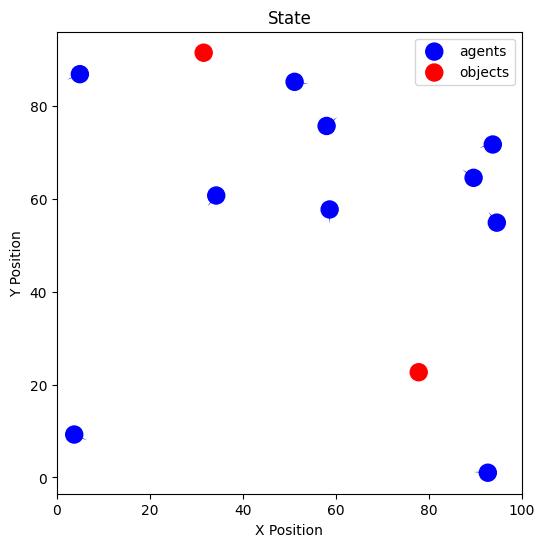

In [8]:
render(state)

### Wrap the state inside a simulator

The simulator needs 3 arguments to be initialized, the initial state (we just created it), a bank of behaviors for the agents and a function to compute the physcis of the simulation (we import these two elements in the next cell).

In [9]:
from vivarium.simulator.behaviors import behavior_bank
from vivarium.simulator.simulator import Simulator
from vivarium.simulator.physics_engine import dynamics_rigid

simulator = Simulator(state, behavior_bank, dynamics_rigid)

If you use a python file, you can init a state with a yaml config file ([example](../conf/scene/default.yaml)) that you select in command line : 

<div style="font-size: 85%;">

```python
from vivarium.simulator.states import init_state

@hydra.main(version_base=None, config_path="../conf", config_name="config")
def main(cfg: DictConfig = None) -> None:

    args = OmegaConf.merge(cfg.default, cfg.scene)
    state = init_state(args)
    simulator = Simulator(state, behaviors.behavior_bank, dynamics_rigid)
```
</div>

### Run a simulation and save it

To run a simulation, we update the initial state at each timestep. By default, agents are assigned an aggressive behavior, causing them to move toward the closest entity within their field of view. The simulation also incorporates physics elements, such as collisions between entities.

All the functions used to compute the next state of the simulation are currently located in the [physcis engine](../vivarium/simulator/physics_engine.py) file. As the simulation progresses, you can save its state for further analysis or visualization.

In [10]:
num_steps = 2000

In [11]:
state_history = []

# Run the simulation for num_steps and save the state
for _ in range(num_steps):
    simulator.step()
    state_history.append((simulator.state.entity_state,
                          simulator.state.agent_state, 
                          simulator.state.object_state, 
                          simulator.state.simulator_state
                          ))

The code above is equivalent to the following lines of code (but it also saves the state history in a pickle file):

In [12]:
saving_name="notebook_tutorial"
simulator.start_recording(saving_name)

simulator.run(num_steps=num_steps, save=True, saving_name=saving_name)

simulator.stop_recording()

Already recording
Recording not started yet.


We can also speed up the simulation by using jax loops ([lax.fori_loop](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html) / [lax.scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html)) instead of classical loops.

In [13]:
# Load the history from the pickle file
loaded_state_history = simulator.load(saving_name)

### Render the state history

After running the simulation for 2000 steps twice, we will combine the two state histories and visualize the entire simulation sequence.

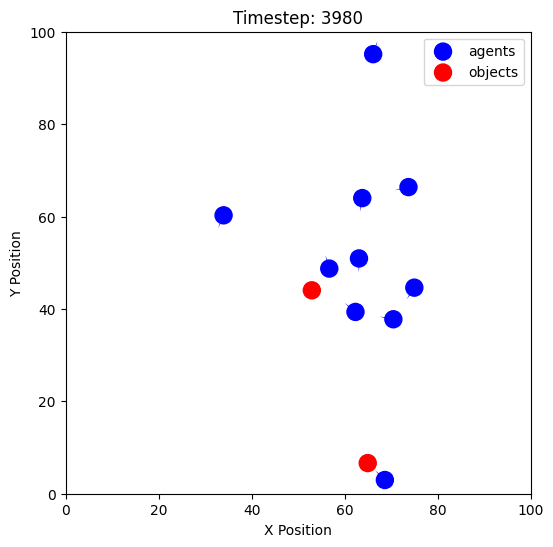

In [14]:
# Here we concatenate the first part (saved with a list), then the second part (saved in the pickle file)
whole_history = state_history + loaded_state_history
skip_frames = 20 # Only plot the state every 20 steps

render_history(whole_history, skip_frames=skip_frames)

### Change the state of a simulation

We are going to modify some elements of the state of half of our agents

In [15]:
# 1: get the current state 
state = simulator.state

agent_state_behavior = state.agent_state.behavior

# 2: change the behavior of the first 5 agents and their color 
updated_agent_behavior = state.agent_state.behavior.at[:5].set(behavior_name_map['FEAR'])
updated_agent_color = state.agent_state.color.at[:5].set(jnp.array([0., 1., 0.]))
updated_agent_speed_mul = state.agent_state.speed_mul.at[:5].set(jnp.array([3.]))

# 3: Update the state with those new values (use dataclass.set(attribute=updated_attribute))
agent_state = state.agent_state.set(behavior=updated_agent_behavior, color=updated_agent_color)
state = state.set(agent_state=agent_state)
simulator.state = state

### Run it and render it 

In [16]:
new_state_history = []

for _ in range(num_steps):
    simulator.step()
    new_state_history.append((simulator.state.entity_state,
                          simulator.state.agent_state, 
                          simulator.state.object_state, 
                          simulator.state.simulator_state
                          ))

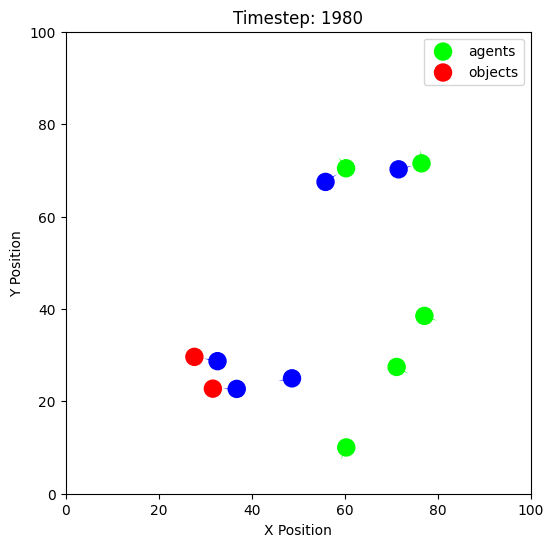

In [17]:
render_history(new_state_history, skip_frames=skip_frames)

### Add and remove entities

In our JAX simulation, we work with fixed-size arrays for agents and objects. However, there might be situations where you want some agents or objects not to exist. To achieve this, you can manipulate the exist field of the entity_state.

To "remove" an entity from the simulation, simply set its corresponding value in the exist field to 0. Conversely, to add an entity, set the value to 1. By doing so, the non-existent entities will no longer interact with other entities in the simulation, meaning there will be no collisions or motor activations for agents. This approach allows you to effectively manage entities within the fixed-size array constraints of the JAX simulation.

In [18]:
state = simulator.state
# Get the entity idx of our agents and objects
agents_idx = state.agent_state.ent_idx
objects_idx = state.object_state.ent_idx

# Let's kill the 3 first agents and remove an object
entities_exist = state.entity_state.exists
entities_exist = entities_exist.at[agents_idx[:3]].set(jnp.array([0]))
entities_exist = entities_exist.at[objects_idx[:1]].set(jnp.array([0]))

entity_state = state.entity_state.set(exists=entities_exist)
state = state.set(entity_state=entity_state)
simulator.state = state

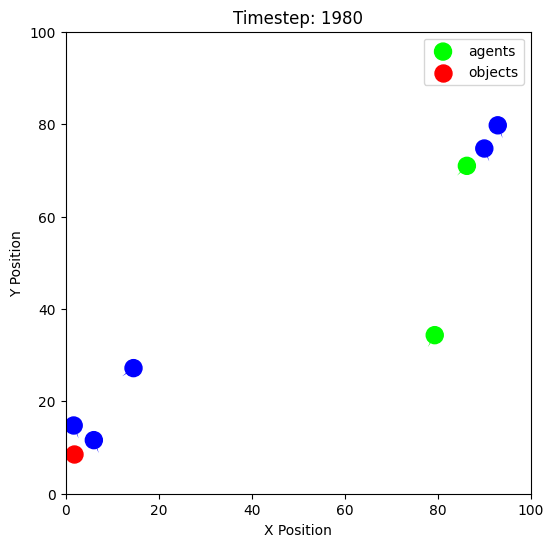

In [19]:
new_state_history = []

for _ in range(num_steps):
    simulator.step()
    new_state_history.append((simulator.state.entity_state,
                          simulator.state.agent_state, 
                          simulator.state.object_state, 
                          simulator.state.simulator_state
                          ))
    
render_history(new_state_history, skip_frames=skip_frames)

And now we indeed only have 2 FEAR agents and 1 object left. If we want to add these entities back, we can simply set their value in the exist attribute back to 1 as follows :

In [20]:
state = simulator.state
entities_exist = state.entity_state.exists
entities_exist = entities_exist.at[agents_idx[:3]].set(jnp.array([1])) # Set back to 1
entities_exist = entities_exist.at[objects_idx[:1]].set(jnp.array([1])) # Set back to 1

entity_state = state.entity_state.set(exists=entities_exist)
state = state.set(entity_state=entity_state)
simulator.state = state

### Implement a custom behavior

To create custom agent behaviors, you need to access their environmental observations to compute their actions (motor activations). You can access three types of information for each agent:

- Proximeter activations
- Relative distances to neighboring entities
- Relative angles with neighboring entities

Using this information, you can design and implement custom behaviors for your agents.

In [21]:
state = simulator.state

# Get the 3 information for each agent
proximter_activations = state.agent_state.prox
proximity_map_dist = state.agent_state.proximity_map_dist
proximity_map_theta = state.agent_state.proximity_map_theta % (2 * jnp.pi)
# Also access the motor values of the agents
motors_activations = state.agent_state.motor

Let's change the color of two agents to better understand the proximity maps :

In [22]:
def change_agent_color(state, ag_idx, color):
    updated_agent_color = state.agent_state.color.at[ag_idx].set(jnp.array(color))
    agent_state = state.agent_state.set(behavior=updated_agent_behavior, color=updated_agent_color)
    state = state.set(agent_state=agent_state)
    return state

source_ag_idx, soure_ag_color = 4, [0., 0., 0.]
target_ag_idx, target_ag_color = 2, [0.5, 0.5, 0.5]
state = change_agent_color(state, source_ag_idx, soure_ag_color)
state = change_agent_color(state, target_ag_idx, target_ag_color)

source agent distance proximity map:
 [30.854101 37.37844  10.677618 37.25915   0.       35.6673   41.522823
 46.96662  35.33408  30.108616 49.524845 34.295208]
source agent angle proximity map:
 [0.19926357 4.070881   6.2734456  3.818387   0.         2.230238
 3.7494526  3.7121487  1.7166109  1.702074   5.811211   1.5706348 ]

source agent distance with target: 10.68
source agent angle with target: 6.27


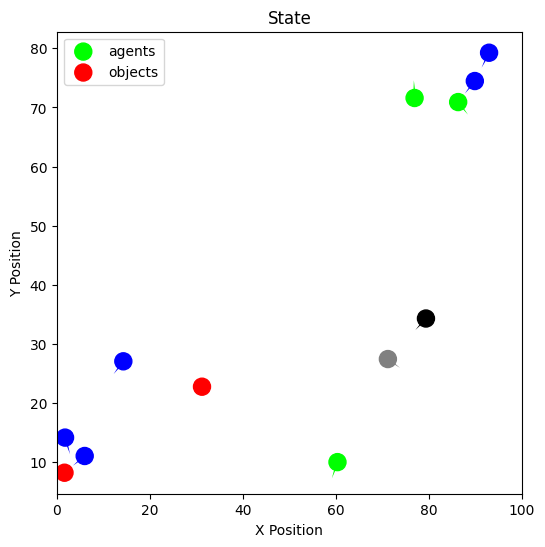


source agent proximter values (left, right): 
[0.14261979 0.        ]
source agent motor activations (left, right): 
[0.14261979 0.        ]


In [23]:
print(f"source agent distance proximity map:\n {proximity_map_dist[source_ag_idx]}")
print(f"source agent angle proximity map:\n {proximity_map_theta[source_ag_idx]}")

print(f"\nsource agent distance with target: {proximity_map_dist[source_ag_idx][target_ag_idx]:.2f}")
print(f"source agent angle with target: {proximity_map_theta[source_ag_idx][target_ag_idx]:.2f}")

render(state)

print(f"\nsource agent proximter values (left, right): \n{proximter_activations[source_ag_idx]}")
print(f"source agent motor activations (left, right): \n{motors_activations[source_ag_idx]}")


In [24]:
jnp.sin(proximity_map_theta[source_ag_idx][target_ag_idx])

Array(-0.00973955, dtype=float32)

We can indeed observe that the target agent (2) is the closest to the source agent (4), with a relative angle nearly equal to 2*pi (meaning the source agent is facing its direction). Consequently, the target agent is the one triggering the proximeter activations of the source agent.

To define the classical behaviors of braitenberg agents, we use these kind of functions (not exactly because these aren't jax functions) where you map the proximeters values of an agent to its motor activations.

In [25]:
def aggression(agent):
    return agent.right_prox, agent.left_prox

def fear(agent):
    return agent.left_prox, agent.right_prox

def love(agent):
    return 1. - agent.left_prox, 1. - agent.right_prox

def shy(agent):
    return 1. - agent.right_prox, 1. - agent.left_prox

If we want to attribute a custom behavior to an agent, we need to set its behavior attribute to manual and implement a custom behavior. For example, we will set the left motor of the black agent to 1 and the left to 0, so it will just keep turning to the left.

In [26]:
behavior = state.agent_state.behavior.at[source_ag_idx].set(behavior_name_map["manual"])
motor = state.agent_state.motor.at[source_ag_idx].set(jnp.array([1., 0.]))
agent_state = state.agent_state.set(behavior=behavior, motor=motor)
simulator.state = simulator.state.set(agent_state=agent_state)

In [27]:
new_state_history = []

for _ in range(num_steps):
    simulator.step()
    new_state_history.append((simulator.state.entity_state,
                          simulator.state.agent_state, 
                          simulator.state.object_state, 
                          simulator.state.simulator_state
                          ))

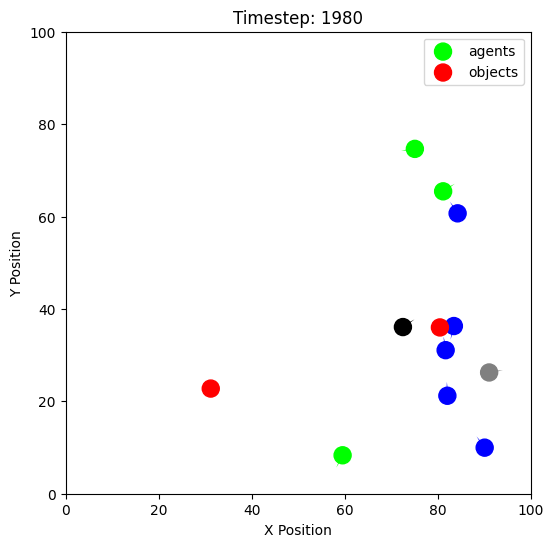

In [28]:
render_history(new_state_history, skip_frames=skip_frames)

Now that you understand the basics of the simulator, you can implement your own custom behaviors.